In [1]:
# Define paths
captions_file = 'Dataset/captions.txt'
images_folder = 'Dataset/Images/'

# Initialize a dictionary to hold image captions
image_captions = {}

# Load captions with reduced output
with open(captions_file, 'r') as file:
    for i, line in enumerate(file):
        parts = line.strip().split(',')  # Comma-separated values
        if len(parts) == 2:
            image_id, caption = parts
            image_id = image_id.split('.')[0]  # Remove image extension
            if image_id in image_captions:
                image_captions[image_id].append(caption)
            else:
                image_captions[image_id] = [caption]
        
        # Print a few lines for debugging
        if i < 5:  # Change this number to print more or fewer lines
            print("Line read:", line.strip())

# Check the loaded data
print(f"Loaded {len(image_captions)} captions.")
print("Sample caption for an image:", image_captions.get('1000268201_693b08cb0e', 'No captions found'))



Line read: 1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
Line read: 1000268201_693b08cb0e.jpg,A girl going into a wooden building .
Line read: 1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
Line read: 1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
Line read: 1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
Loaded 8091 captions.
Sample caption for an image: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [32]:
from collections import defaultdict
import string

def preprocess_caption(captions):
    # Create a vocabulary dictionary
    vocab = defaultdict(int)
    sample_limit = 5  # Limit for printed samples
    printed_samples = 0  # Counter for printed samples
    
    # Preprocess captions
    for image_id, caption_list in captions.items():
        for caption in caption_list:
            # Lowercase, remove punctuation, and tokenize
            caption = caption.lower()
            caption = caption.translate(str.maketrans('', '', string.punctuation))
            tokens = caption.split()
            
            # Update the vocabulary
            for token in tokens:
                vocab[token] += 1

            # Print a sample processed caption
            if printed_samples < sample_limit:
                print(f"Processed caption for {image_id}: {tokens[:5]}...")  # Show first 5 tokens
                printed_samples += 1
            
    return vocab

# Preprocess the loaded captions
vocabulary = preprocess_caption(image_captions)

# Print the size of the vocabulary
print(f"Vocabulary size: {len(vocabulary)}")


8517


In [35]:
# Create word-to-index and index-to-word mappings
word_to_index = {word: index + 1 for index, (word, _) in enumerate(vocabulary.items())}  # Start indexing at 1
index_to_word = {index: word for word, index in word_to_index.items()}

# Print size of vocabulary and sample mappings
print(f"Vocabulary size: {len(word_to_index)}")
print(f"Sample word to index mapping: {list(word_to_index.items())[:5]}")  # First 5 mappings


In [4]:
import string

def convert_captions_to_sequences(captions, word_to_index):
    sequences = {}
    
    for image_id, caption_list in captions.items():
        sequences[image_id] = []  # Initialize a list to hold all sequences for this image
        for caption in caption_list:
            tokens = caption.lower().translate(str.maketrans('', '', string.punctuation)).split()
            sequence = [word_to_index[token] for token in tokens if token in word_to_index]
            sequences[image_id].append(sequence)  # Append each sequence to the list
            
    return sequences

# Convert captions to sequences
caption_sequences = convert_captions_to_sequences(image_captions, word_to_index)

# Print a sample sequence
print("Sample caption sequences for an image:", caption_sequences.get(list(caption_sequences.keys())[0]))
print(list(caption_sequences.keys())[0])


In [5]:
import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from PIL import Image
import os


In [6]:
# Load the Inception V3 model with default pre-trained weights
model = inception_v3(weights=Inception_V3_Weights.DEFAULT)
model.eval()  # Set the model to evaluation mode

# Check the number of trainable parameters without verbose output
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params:,}")  # Formats the number with commas for readability


Number of trainable parameters: 27,161,264


In [7]:
def load_and_preprocess_images(image_folder):
    images = []
    preprocess = transforms.Compose([
        transforms.Resize((299, 299)),  # Resize the image
        transforms.ToTensor(),           # Convert the image to a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
    ])
    
    for img_name in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_name)
        image = Image.open(img_path).convert('RGB')  # Open the image and ensure it's in RGB mode
        image = preprocess(image)  # Apply the preprocessing
        images.append(image)  # Add the processed image to the list
    
    return images


In [8]:
# Use the function to load and preprocess the images
image_folder = 'Dataset/Images'  # Path to the folder containing the images
processed_images = load_and_preprocess_images(image_folder)

# Check if images are processed correctly
print(f"Processed {len(processed_images)} images")

Processed 8091 images


In [9]:
def match_images_with_captions(image_folder, captions_dict):
    # Get the filenames of the processed images
    image_filenames = sorted(os.listdir(image_folder))  # Sort to maintain order

    # Create a dictionary for image-caption pairs
    image_caption_pairs = {}
    
    for filename in image_filenames:
        image_name = filename.split('.')[0]  # Strip the file extension
        if image_name in captions_dict:
            image_caption_pairs[filename] = captions_dict[image_name]  # Match image with its captions
    
    return image_caption_pairs

# Match the images with the preprocessed captions using the dictionary
image_caption_pairs = match_images_with_captions(image_folder, caption_sequences)

# Check the first few pairs to verify everything is matched correctly
for key in list(image_caption_pairs.keys())[:5]:
    print(f"{key}: {image_caption_pairs[key]}")


1000268201_693b08cb0e.jpg: [[1, 2, 3, 1, 4, 5, 6, 7, 8, 1, 9, 10, 11, 3, 12, 13, 14], [1, 15, 16, 17, 1, 18, 19], [1, 20, 15, 7, 17, 1, 18, 21], [1, 20, 15, 7, 22, 11, 23, 24, 21], [1, 20, 15, 3, 1, 4, 5, 16, 17, 1, 18, 25]]
1001773457_577c3a7d70.jpg: [[1, 26, 27, 28, 1, 29, 27, 30, 31], [1, 26, 27, 28, 1, 32, 27, 33, 34, 35, 36, 37, 22, 38], [1, 26, 27, 28, 1, 39, 27, 34, 40, 41, 30, 42, 43, 35, 36, 3, 22, 44], [45, 46, 10, 47, 48, 49, 43, 35, 36, 37, 22, 38], [45, 46, 37, 50, 51, 52, 35, 36]]
1002674143_1b742ab4b8.jpg: [[1, 20, 15, 53, 3, 54, 55, 3, 56, 10, 1, 57, 58, 34, 24, 59, 3, 1, 60], [1, 20, 15, 6, 61, 3, 56, 10, 1, 62, 57, 58], [1, 63, 15, 3, 22, 64, 65, 34, 66, 3, 56, 10, 1, 39, 67, 34, 1, 58, 37, 68], [69, 6, 1, 15, 34, 70, 61, 3, 56, 10, 1, 58, 71], [72, 15, 34, 70, 71, 73, 3, 22, 64]]
1003163366_44323f5815.jpg: [[1, 74, 75, 37, 1, 76, 77, 78, 27, 55, 79, 80], [1, 74, 75, 37, 22, 76, 23, 81, 1, 39, 27, 6, 82, 83], [1, 74, 84, 37, 1, 76, 73, 34, 1, 39, 28, 26, 27, 61, 85, 2

In [10]:
def check_total_pairs(image_caption_pairs):
    print(f"Total number of image-caption pairs: {len(image_caption_pairs)}")

check_total_pairs(image_caption_pairs)


Total number of image-caption pairs: 8091


In [11]:
import random

def sample_image_caption_pairs(image_caption_dict, sample_size=5):
    # Sample random pairs from the dictionary items
    sampled_pairs = random.sample(list(image_caption_dict.items()), sample_size)
    
    for image_name, captions in sampled_pairs:
        print(f"Image: {image_name}")
        for i, caption in enumerate(captions):
            print(f"  Caption {i + 1}: {caption}")

# Print 5 random image-caption pairs
sample_image_caption_pairs(image_caption_pairs, sample_size=5)



Image: 3166578139_33500f7e8a.jpg
  Caption 1: [1, 5432, 176, 1270, 22, 3711, 37, 1, 504, 450]
  Caption 2: [1, 181, 641, 3, 26, 646, 379, 1, 171, 53, 340]
  Caption 3: [1, 181, 177, 379, 1, 337, 340]
  Caption 4: [1, 176, 37, 1, 478, 503, 898]
  Caption 5: [176, 646, 2985]
Image: 396360611_941e5849a3.jpg
  Caption 1: [1, 74, 198, 738, 37, 22, 694]
  Caption 2: [1, 74, 198, 37, 1, 469, 189, 370, 1, 252, 10, 134]
  Caption 3: [1, 181, 6, 135, 37, 739, 694, 377, 22, 134, 386]
  Caption 4: [1, 181, 34, 1, 328, 198, 37, 1, 469, 1039, 921, 1, 252, 10, 134]
  Caption 5: [181, 135, 37, 469, 130, 10, 134, 34, 2009, 1569, 3, 474]
Image: 3658427967_6e2e57458d.jpg
  Caption 1: [1, 140, 3, 1, 717, 168, 17, 134]
  Caption 2: [1, 140, 3, 156, 1398, 282, 168, 17, 134]
  Caption 3: [1, 140, 6, 216, 23, 407, 17, 22, 134]
  Caption 4: [1, 140, 226, 17, 22, 134, 43, 1, 131]
  Caption 5: [1, 72, 74, 159, 17, 22, 134]
Image: 2662537919_18a29fca8a.jpg
  Caption 1: [1, 602, 1802, 10, 1, 1077, 1004, 74, 33, 1,

Image: 2650568697_ffb79bf2ea.jpg


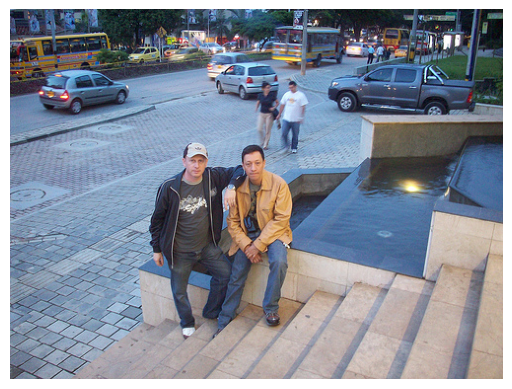

  Caption 1: two guys are posing next to each other on the steps of a building with traffic behind them
  Caption 2: two men are sitting on steps in front of a city building
  Caption 3: two men pose at the bottom of a set of steps in a metropolitain area
  Caption 4: two men sit together beside stone steps in an urban setting
Image: 2144846312_d4c738dc6c.jpg


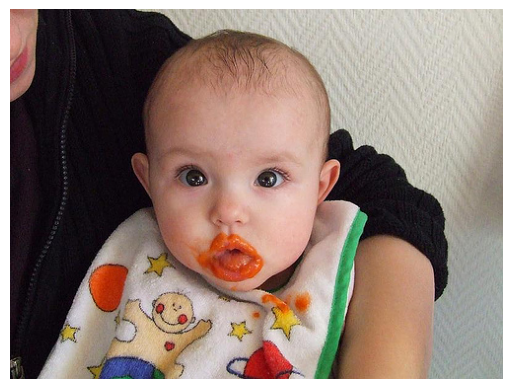

  Caption 1: a baby with food all over its mouth
  Caption 2: a little boy with baby food on his face
  Caption 3: the baby is wearing a bib and sitting in an adult
  Caption 4: there is a baby with orangestained lips staring at the camera
Image: 3222041930_f642f49d28.jpg


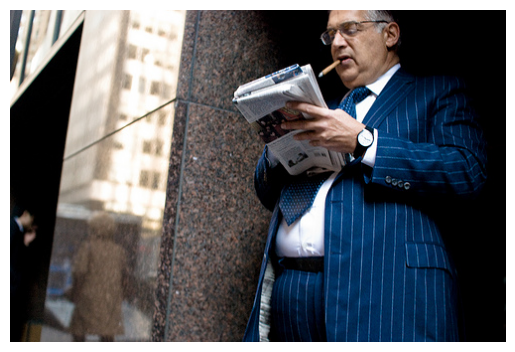

  Caption 1: a man in a blue pinstriped suit is reading a newspaper while smoking a cigar
  Caption 2: a man in a blue suit reads the paper while smoking next to a marble building
  Caption 3: a man smoking a cigar reading a paper in a city
  Caption 4: a man standing by a building corner and reading a newspaper
Image: 468930779_8008d90e10.jpg


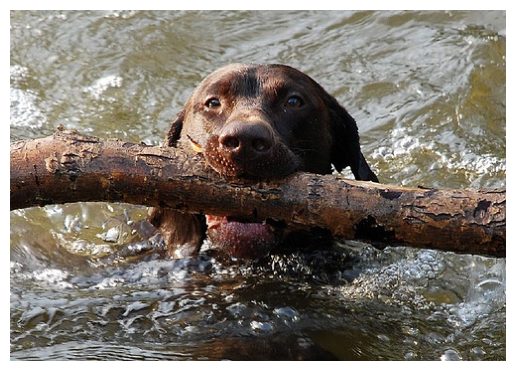

  Caption 1: a brown dog carrying a stick in its mouth
  Caption 2: a dog has its head coming up from the water as it holds a stick
  Caption 3: a dog swimming with a stick in its mouth
  Caption 4: a swimming dog with a small branch in its mouth
  Caption 5: closeup of a brown dog in the water holding a very large stick
Image: 2114355355_9d7e2d8178.jpg


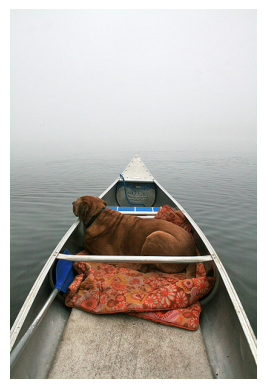

  Caption 1: a brown dog is sitting in the front of a canoe
  Caption 2: a brown dog lies on a blanket in boat
  Caption 3: a dog lies at the front of a boat headed into the fog
  Caption 4: a dog lying on a blanket at the end of a small boat
  Caption 5: a reddishbrown dog is laying at the front of a white boat on an orange flowered blanket


In [12]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

def show_image(image_path):
    try:
        # Open the image and ensure it's in RGB mode
        image = Image.open(image_path).convert('RGB')
        plt.imshow(image)
        plt.axis('off')  # Turn off axis labels to improve the visual
        plt.show()
    except Exception as e:
        print(f"Error displaying image at {image_path}: {e}")

def decode_caption(caption_sequence, vocab):
    # Convert the sequence of numbers into words using the vocabulary
    return ' '.join([vocab.get(word_id, '[UNK]') for word_id in caption_sequence])  # Assuming `vocab` is the mapping dictionary

def sample_image_caption_pairs_with_decoded(image_caption_dict, vocab, image_folder, sample_size=5):
    # Sample random pairs from the dictionary items
    sampled_pairs = random.sample(list(image_caption_dict.items()), sample_size)
    
    for image_name, captions in sampled_pairs:
        image_path = os.path.join(image_folder, image_name)  # Get the full image path
        print(f"Image: {image_name}")
        show_image(image_path)  # Display the image
        for i, caption in enumerate(captions):
            decoded_caption = decode_caption(caption, vocab)
            print(f"  Caption {i + 1}: {decoded_caption}")

# Provide the correct folder path to your images
image_folder = 'V:\\Codes\\Python\\ImageCaption\\Dataset\\Images'

# Assuming `vocab` is the dictionary that maps word IDs to actual words
sample_image_caption_pairs_with_decoded(image_caption_pairs, index_to_word, image_folder, sample_size=5)


In [13]:
import torch
import torchvision.models as models

# Load Inception V3 pre-trained on ImageNet
inception_model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

# Set the model to evaluation mode (important for inference)
inception_model.eval()

# Print the model architecture to check the layers
print(inception_model)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [14]:
import os

image_folder = 'Dataset/Images'
image_paths = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith('.jpg')]

# Now image_paths contains the full paths to all image files in the folder
print(image_paths[:5])  # Prints the first 5 image paths for verification

['Dataset/Images\\1000268201_693b08cb0e.jpg', 'Dataset/Images\\1001773457_577c3a7d70.jpg', 'Dataset/Images\\1002674143_1b742ab4b8.jpg', 'Dataset/Images\\1003163366_44323f5815.jpg', 'Dataset/Images\\1007129816_e794419615.jpg']


In [ ]:
import torch
import numpy as np

# Dictionary to map image names to indices
image_name_to_index = {}

# List to store extracted features
all_features = []

# Process images in batches
batch_size = 16
for i in range(0, len(processed_images), batch_size):
    batch = processed_images[i:i + batch_size]
    batch_tensor = torch.stack(batch)
    
    # Extract features using your model (Inception v3)
    with torch.no_grad():
        batch_features = model(batch_tensor)
    
    # Store features and map image names to their index
    for j, image_tensor in enumerate(batch):
        image_name = os.path.basename(image_paths[i + j]).replace('.jpg', '')  # Extract image name
        all_features.append(batch_features[j].cpu().numpy())  # Store feature as NumPy array
        image_name_to_index[image_name] = len(all_features) - 1  # Map image name to index

# Convert features to NumPy array for saving
all_features_array = np.array(all_features)

# Save the features and mapping dictionary
np.save('image_features.npy', all_features_array)
np.save('image_name_to_index.npy', image_name_to_index)

print("Feature extraction complete and saved!")
